In [620]:
using Revise
using HypergraphDetectability
using DataFrames
using Clustering
using Statistics
using RCall
using Arpack
using Plots
using StatsBase
using SparseArrays
using Kronecker: ⊗
using LinearAlgebra
using SparseArrays

In [621]:
n  = 100
c₂ = 5
c₃ = 5
z  = 1 .+ (1:n .> n/2);

p₂ = 0.7
p₃ = 0.9

H = detectabilityData(n, c₂, c₃, p₂, p₃);

In [622]:
BP_mat, ix = linearizedBPMatrix(H, z); 

In [623]:
@time E = Arpack.eigs(BP_mat; nev = 3, ritzvec = true, tol = 1e-10);

  0.121616 seconds (1.30 k allocations: 982.812 KiB, 11.80% gc time)


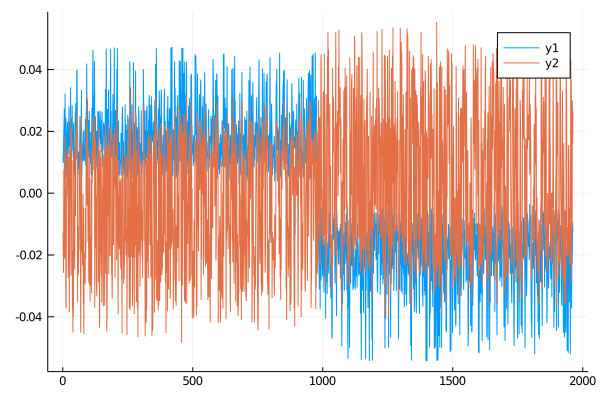

In [624]:
# looks like cluster info is lost
u = E[2][:,1]
plot(real.(u))

u = E[2][:,2]
plot!(real.(u))

In [625]:
u = aggregateEigenvector(E[2][:,2], ix);
clusters = 1 .+ (real.(u) .> 0)
mi = mutualinfo(clusters, z)

0.7610260716417303

# BP Jacobian Reduction: Scratchwork

First, let's compute the true spectrum of the BP Jacobian. This is the spectrum which we would like to reproduce in a reduced version of the matrix. 

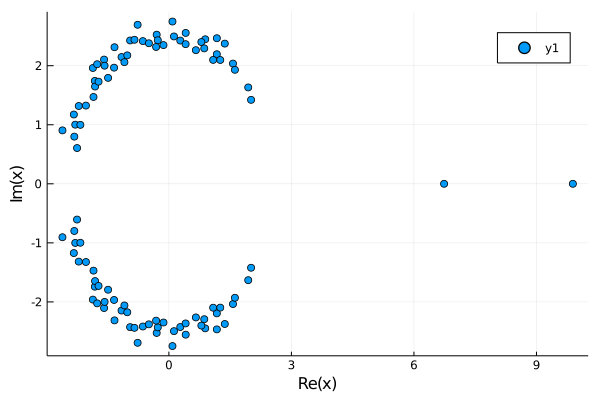

In [626]:
BP_mat, ix = linearizedBPMatrix(H, z);
E = Arpack.eigs(BP_mat; nev = 100)
plot(E[1], seriestype = :scatter)
# plot!(xlim = (-1, 1), ylim = (-1, 1))

So, let's see if we can reproduce this. Fundamentally, all we need to do is construct a matrix of the correct dimensions and check its spectrum. 

In [627]:
K_ = sort(collect(keys(H.E)))
c, G = degreeTensor(H, z);
ẑ = z
q = 1/n * StatsBase.counts(ẑ)
G_ = zero(G)
for i ∈ 1:length(K_)
    G_[i,:,:] = (G[i,:,:] / ((K_[i] - 1) * c[i]) .- 1) .* q
end

In [628]:
G_[2, :, :]

2×2 Array{Float64,2}:
  0.324242  -0.39899
 -0.39899    0.473737

In [629]:
ℓ = length(unique(z))

for l ∈ 1:ℓ, i ∈ 1:length(K_)
    println(G_[i,l,:])
end

C = [zeros(ℓ, length(K_)) for i ∈ 1:ℓ]

for l ∈ 1:ℓ, i ∈ 1:length(K_)
    C[l][i, :] = G_[i, l, :]
end
C

[0.191358024691358, -0.17489711934156377]
[0.3242424242424242, -0.398989898989899]
[-0.17489711934156377, 0.15843621399176955]
[-0.398989898989899, 0.4737373737373738]


2-element Array{Array{Float64,2},1}:
 [0.191358024691358 -0.17489711934156377; 0.3242424242424242 -0.398989898989899]
 [-0.17489711934156377 0.15843621399176955; -0.398989898989899 0.4737373737373738]

In [630]:
# diagonal matrix of edge sizes
K = diagm(K_)

n = length(H.D)

# degree diagonal matrix

d = [HypergraphDetectability.degreeMatrix(H, k) for k ∈ K_]
D = cat(d..., dims = (1, 2))

# A = HypergraphDetectability.adjacencyBlockMatrix(H);

# adjacency matrix (diagonal)
a = [HypergraphDetectability.adjacencyMatrix(H, k) for k ∈ K_]
A = cat(a..., dims = (1, 2));

In [631]:
ℓ = length(unique(z))

Cs = [G_[i,:,:] for i ∈ 1:length(K_)]

sumC = sum(Cs)
C = cat(Cs..., dims=(1,2))

# think this is kind of not "stacked" right: stacked so that the outermost index is k, 
# when what we want is for the outermost index to be ℓ...
bigC = hcat(Cs...)
bigC = vcat([bigC for i ∈ 1:length(K_)]...)

# bigC
# # upper-right block? 

upperRight = sparse(I(ℓ) ⊗ D) * sparse((bigC ⊗ I(n)))    - sparse(C ⊗ I(n))
size(upperRight) # correct dimensions

(400, 400)

In [632]:
# lower lefthand corner? 
lowerLeft = sparse((C * (I(ℓ)⊗(I - K))) ⊗ I(n));
size(lowerLeft)

(400, 400)

In [633]:
lowerRight =  sparse((bigC ⊗ I(n))) * ((I(ℓ) ⊗ A)) - (C*(I(ℓ)⊗(K - 2I)))⊗I(n);
size(lowerRight)

(400, 400)

In [634]:
B_ = hcat(zero(upperRight), upperRight);
B_ = vcat(B_, hcat(lowerLeft, lowerRight));

In [635]:
E_ = Arpack.eigs(B_; nev = 100);

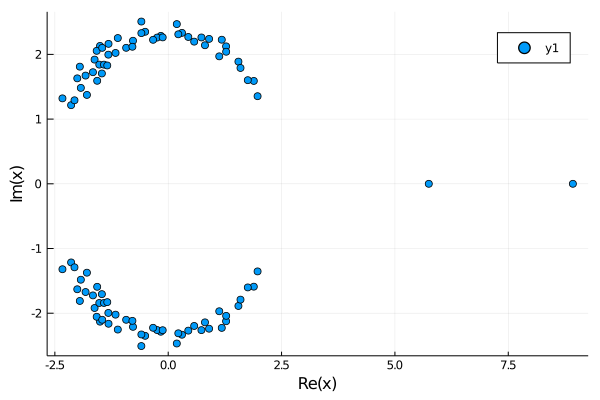

In [636]:
# getting there...ish

plot(E_[1], seriestype = :scatter)
# plot!(xlim = (-1, 1), ylim = (-1, 1))